In [1]:
%matplotlib inline

import os.path as path
import stripy as stripack
import numpy as np

import pyproj

import cartopy
import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt



In [2]:
def spherical_midpoints(interpolator):

    import pyproj
    
    lst = interpolator.lst
    lend = interpolator.lend
    lptr = interpolator.lptr

    g = pyproj.Geod(ellps='WGS84')

    midlon_array = np.ones((len(lptr))) * -99999.0
    midlat_array = np.ones((len(lptr))) * -99999.0
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats


    for i in range(0,len(lptr),1):
        n1 = lst[i]-1
        n2 = lst[lptr[i]-1]-1
        if n1 < n2:
            midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
            midlon_array[i] = midlonlat[0]
            midlat_array[i] = midlonlat[1]
            
    valid_points =  np.where(midlon_array != -99999.0 )    

    midlon_array = midlon_array[valid_points[0]]
    midlat_array = midlat_array[valid_points[0]]
    
   
    return midlon_array, midlat_array


def subdivide_triangle(tri, interpolator):
    """
    Add midpoints to sides of triangle tri={n1, n2, n3}
    """
    
    import pyproj
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    # Easiest is to do this by hand, I think
    
    (n1, n2, n3) = tri

    midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n2],latv1[n2],lonv1[n3],latv1[n3], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    midlonlat, = g.npts(lonv1[n3],latv1[n3],lonv1[n1],latv1[n1], 1 , radians=True )
    midlon.append(midlonlat[0])
    midlat.append(midlonlat[1])

    return np.array(midlon), np.array(midlat)


def subdivide_node_list(nodes_to_refine, interpolator):
    
    segments = []

    for node in nodes_to_refine:
        neighbours = node_neighbours(node, interpolator)
    
    for n1 in neighbours:
        segments.append( min( tuple((node, n1)), tuple((n1, node))) )

    # Unique entries only
    segList = sorted(list(set(segments)))
    
    new_nodes = split_segments(segList, interpolator)
    
    return new_nodes
    
                                      

def add_spherical_midpoints(interpolator):   
    
    midlon_array, midlat_array = spherical_midpoints(interpolator)
    
    lonv2 = np.concatenate((interpolator.lons, midlon_array), axis=0)
    latv2 = np.concatenate((interpolator.lats, midlat_array), axis=0)
    
    return np.degrees(lonv2), np.degrees(latv2)
    

def node_neighbours(node, interpolator):
    
    lpl = interpolator.lend[node-1]
    lp = lpl
    k = 1

    neighbours = []

    while True:
        lp = interpolator.lptr[lp-1]
        neighbours.append(interpolator.lst[lp-1])
        if (lp == lpl):
            break
        k += 1

    return neighbours
 
    
    
def split_segments(segList, interpolator):  
    
    import pyproj 
    
    g = pyproj.Geod(ellps='WGS84')

    midlon=[]
    midlat=[]
    
    lonv1 = interpolator.lons
    latv1 = interpolator.lats
    
    for segment in segList:
    
        n1 = segment[0]-1
        n2 = segment[1]-1
    
        midlonlat, = g.npts(lonv1[n1],latv1[n1],lonv1[n2],latv1[n2], 1 , radians=True )

        midlon.append(midlonlat[0])
        midlat.append(midlonlat[1])

    
    return np.array(midlon), np.array(midlat)




In [3]:
# Note, first three points must not be co-linear (i.e. on a great circle)

octahedral_vertices = np.array([
    [ 90.0,      0.0],
    [  0.0,      0.0],
    [  0.0,     90.0],
    [  0.0,    180.0],
    [  0.0,    -90.0],
    [-90.0,    180.0]]
)


icosohedral_vertices = np.array([
    [ 90.00,      0.0 ],
    [ 26.57,      0.0 ], 
    [ 26.57,     72.0 ],
    [ 26.57,    144.0 ],
    [ 26.57,   -144.0 ],
    [ 26.57,    -72.0 ],
    [-26.57,     36.0 ], 
    [-26.57,    108.0 ],        
    [-26.57,    180.0 ],        
    [-26.57,   -108.0 ],
    [-26.57,    -36.0 ],
    [-90.00,      0.0 ],

]        
)


# vertices_lat = octahedral_vertices.T[0]
# vertices_lon = octahedral_vertices.T[1]

vertices_lat = icosohedral_vertices.T[0]
vertices_lon = icosohedral_vertices.T[1]



In [4]:
interpolator0 = stripack.trmesh(np.radians(vertices_lon), np.radians(vertices_lat) )

# subdivide a number of times

lonv1, latv1 = add_spherical_midpoints(interpolator0)
interpolator1 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator1)
interpolator2 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator2)
interpolator3 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator3)
interpolator4 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator4)
interpolator5 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator5)
interpolator6 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

lonv1, latv1 = add_spherical_midpoints(interpolator6)
interpolator7 = stripack.trmesh(np.radians(lonv1), np.radians(latv1) )

print "Size of mesh - 1 ", interpolator1.npts
print "Size of mesh - 2 ", interpolator2.npts
print "Size of mesh - 3 ", interpolator3.npts
print "Size of mesh - 4 ", interpolator4.npts
print "Size of mesh - 5 ", interpolator5.npts
print "Size of mesh - 6 ", interpolator6.npts
print "Size of mesh - 7 ", interpolator7.npts

Size of mesh - 1  42
Size of mesh - 2  162
Size of mesh - 3  642
Size of mesh - 4  2562
Size of mesh - 5  10242
Size of mesh - 6  40962
Size of mesh - 7  163842


In [5]:
nt, triangles = interpolator0.tri_list()
print triangles.T

[[ 1  5  6]
 [ 1  6  2]
 [ 1  2  3]
 [ 1  3  4]
 [ 1  4  5]
 [ 2 11  7]
 [ 2  7  3]
 [ 2  6 11]
 [ 3  7  8]
 [ 3  8  4]
 [ 4  8  9]
 [ 4  9  5]
 [ 5  9 10]
 [ 5 10  6]
 [ 6 10 11]
 [ 7 11 12]
 [ 7 12  8]
 [ 8 12  9]
 [ 9 12 10]
 [10 12 11]]


In [16]:
bcc, nodes = interpolator0.find_point([170.0,],[80.0,])

tri = nodes[0]

print bcc, tri

[array([ 0.09475579,  0.863399  ,  0.04184521])] (9, 12, 10)


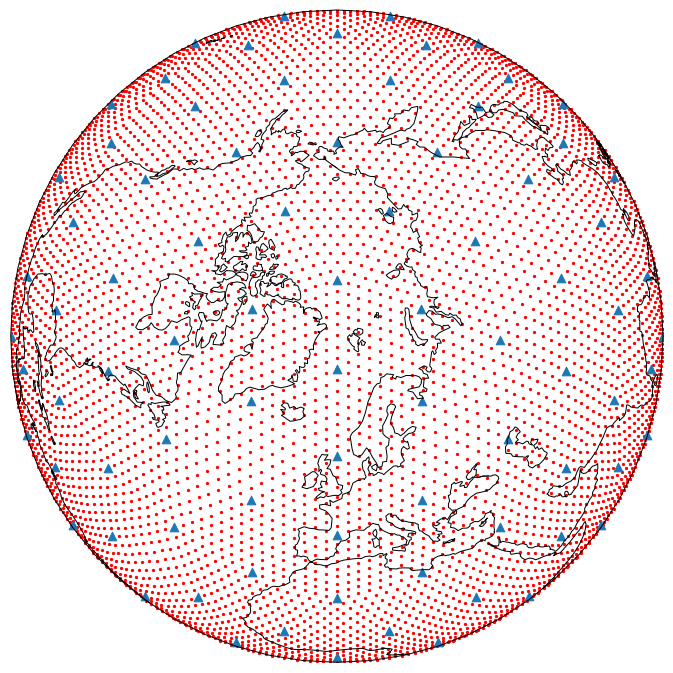

In [25]:
%matplotlib inline

import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection1)
ax.coastlines()
ax.set_global()

plot_interpolator = interpolator5

lons = np.degrees(plot_interpolator.lons)
lats = np.degrees(plot_interpolator.lats)

ax.scatter(lons, lats, color="Red",
            marker="o", s=5.0, transform=ccrs.Geodetic())

plot_interpolator = interpolator2

lons = np.degrees(plot_interpolator.lons)
lats = np.degrees(plot_interpolator.lats)

ax.scatter(lons, lats, 
            marker="^", s=75.0, transform=ccrs.Geodetic())


In [8]:
interp = interpolator0

nodes_to_refine = [ 1  ]

segments = []

for node in nodes_to_refine:
    neighbours = node_neighbours(node, interp)
    
    for n1 in neighbours:
        segments.append( min( tuple((node, n1)), tuple((n1, node))) )

# Unique entries only
segList = sorted(list(set(segments)))

print segList

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]


In [9]:
points = subdivide_node_list([1,], interpolator0)

lonv2 = np.concatenate((interpolator0.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator0.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

In [10]:
points

(array([ 0.        ,  1.25663706,  2.51327412, -2.51327412, -1.25663706]),
 array([ 1.01851088,  1.01851088,  1.01851088,  1.01851088,  1.01851088]))

In [11]:
points = split_segments(segList, interpolator0)

lonv2 = np.concatenate((interpolator0.lons, points[0]), axis=0)
latv2 = np.concatenate((interpolator0.lats, points[1]), axis=0)

interpolator1x = stripack.trmesh(lonv2, latv2)

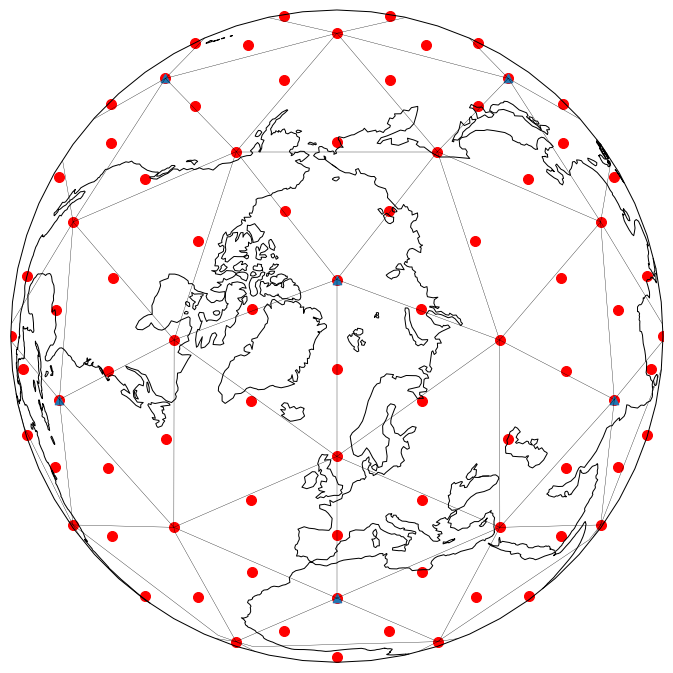

In [24]:
%matplotlib inline

import gdal
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

global_extent     = [-180.0, 180.0, -90.0, 90.0]

projection1 = ccrs.Orthographic(central_longitude=0.0, central_latitude=80, globe=None)
projection2 = ccrs.Mollweide(central_longitude=-120)
projection3 = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(111, projection=projection1)
ax.coastlines()
ax.set_global()

plot_interpolator = interpolator2


lons = np.degrees(plot_interpolator.lons)
lats = np.degrees(plot_interpolator.lats)

ax.scatter(lons, lats, color="Red",
            marker="o", s=100.0, transform=ccrs.Geodetic())

plot_interpolator = interpolator0

lons = np.degrees(plot_interpolator.lons)
lats = np.degrees(plot_interpolator.lats)

ax.scatter(lons, lats, 
            marker="^", s=75.0, transform=ccrs.Geodetic())


# plt.colorbar(mappable=m, orientation="horizontal", shrink=0.5)

plot_interpolator = interpolator1


lst  = plot_interpolator.lst
lptr = plot_interpolator.lptr

lons = np.degrees(plot_interpolator.lons)
lats = np.degrees(plot_interpolator.lats)

for i in range(0,len(lst),1):
    n1 = lst[i]-1
    n2 = lst[lptr[i]-1]-1
    if n1 < n2:
        ax.plot( [lons[n1], lons[n2]],
                 [lats[n1], lats[n2]], 
                  linewidth=0.33, color="black", transform=ccrs.Geodetic())
    
# ax.scatter(lonv1, latv1, marker="s", transform=ccrs.Geodetic())